# This project is a deep dive into online store data. Together with the marketing department, we compiled a list of hypotheses that may help boost revenue.

## We will prioritize these hypotheses, launch an A/B test, and analyze the results.

In [1]:
!pip install sidetable

In [2]:
import pandas as pd
import sidetable
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [3]:
# to begin, we will take a look at our given datasets
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

In [4]:
hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
# looking at column datatypes & memory usage
hypotheses.info()
orders.info()
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (tota

In [8]:
# changing appropriate columns to categories
orders['group'] = orders['group'].astype('category')
visits['group'] = visits['group'].astype('category')

In [9]:
# changing appropriate columns to datetime
orders['date'] = orders['date'].astype('datetime64')
visits['date'] = visits['date'].astype('datetime64')

In [10]:
orders.info()
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 38.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.3 KB


In [11]:
# looking for missing values
orders.stb.missing(style=True)

,missing,total,percent
transactionId,0,"1,197",0.00%
visitorId,0,"1,197",0.00%
date,0,"1,197",0.00%
revenue,0,"1,197",0.00%
group,0,"1,197",0.00%


In [12]:
visits.stb.missing(style=True)

,missing,total,percent
date,0,62,0.00%
group,0,62,0.00%
visits,0,62,0.00%


In [13]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())

0
0


In [14]:
# let's make sure there aren't any IDs in two simultaneous groups
group_check = orders.groupby('visitorId').agg({'group': 'nunique'}).reset_index()
group_check.columns = ['visitorId', 'group_check']
print(orders.shape)

orders=pd.merge(orders, group_check, on='visitorId')
print(orders.shape)

orders = orders[orders['group_check']<2]
print(orders.shape)

(1197, 5)
(1197, 6)
(1016, 6)


#### Conclusion
##### - data is clean, column types properly adjusted
##### - no missing or duplicate data
##### - removed ~ 100 visitorIds that were in both A and B groups

# Prioritizing Hypotheses

In [15]:
# ICE framework = ( Impact x Confidence / Effort )
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']
pd.set_option('display.max_colwidth', 1000)
display(hypotheses[['Hypothesis', 'ICE']].sort_values('ICE', ascending = False))

,Hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000
1,Launch your own delivery service. This will shorten delivery time,2.000000
5,Add a customer review page. This will increase the number of orders,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.125000
4,Change the background color on the main page. This will increase user engagement,1.000000


<div class="alert alert-block alert-success"> <b>Reviewer's comment</b> <a 
class="tocSkip"></a>
    
Super that you use pd.set_option('display.max_colwidth', 1000)</div>

In [16]:
# RICE framework = ( Reach * Impact * Confidence / Effort)
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']
display(hypotheses[['Hypothesis', 'RICE']].sort_values('RICE', ascending = False))

,Hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


In [17]:
# how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.

#### Conclusion
##### - When we add Reach to our ICE framework, the order of effectiveness changes. Reach gives us an idea of the 'width' of our impact - we want our efforts to have a high level of Reach, so we can feel confident that our actions are being seen.
##### - We see that once Reach is added, a subscription form becomes the most impactful action we can take.
##### - Product recommendations move up on the priority list as well.
##### - Our birthday discount promotion that was #1 on our ICE list has fallen several spots to a middle of the pack action in terms of RICE.

# A/B Test Analysis

In [18]:
# Graph cumulative revenue by group. Make conclusions and conjectures.

In [19]:
orders_A = orders[orders['group'] == 'A']
orders_A = orders_A.groupby('date').agg({'revenue':'sum', 'group_check':'count'}).reset_index()
orders_A = orders_A.sort_values('date')
orders_A.columns = ['date', 'revenue', 'orders']

orders_B = orders[orders['group']== 'B']
orders_B = orders_B.groupby('date').agg({'revenue':'sum', 'group_check':'count'}).reset_index()
orders_B = orders_B.sort_values('date')
orders_B.columns = ['date', 'revenue', 'orders']

In [20]:
orders_A['cum_revenue'] = orders_A['revenue'].cumsum()
orders_B['cum_revenue'] = orders_B['revenue'].cumsum()

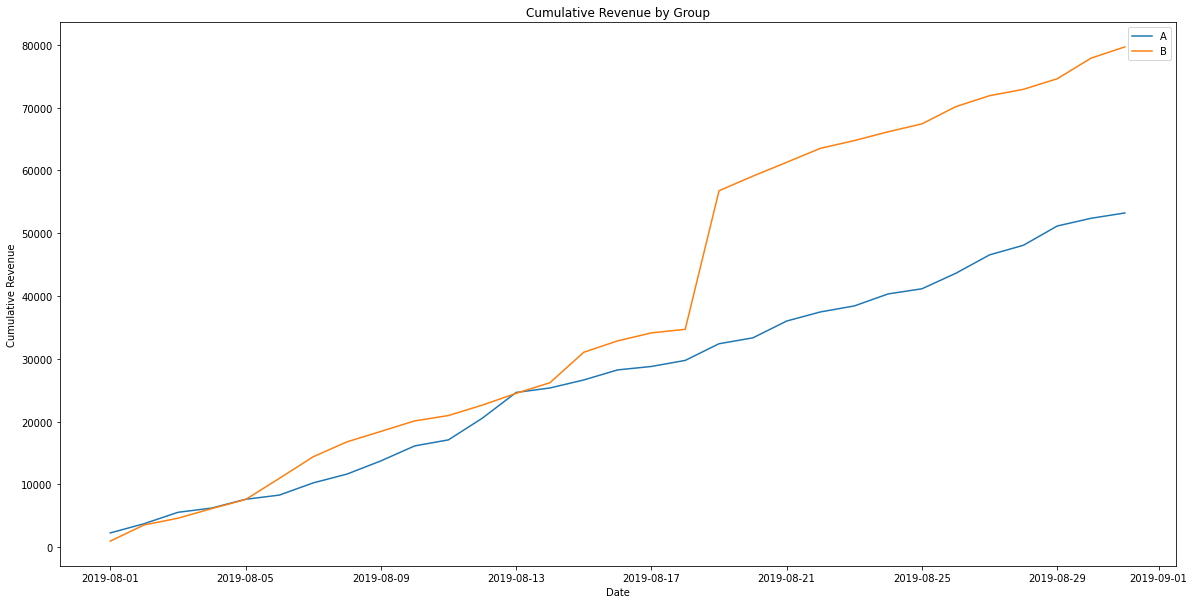

In [21]:
plt.figure(figsize = (20, 10))
plt.plot(orders_A['date'], orders_A['cum_revenue'], label='A')
plt.plot(orders_B['date'], orders_B['cum_revenue'], label='B')
plt.title('Cumulative Revenue by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.legend()

#### Conclusion
##### - While trending in a similar fashion at first, around the 18th of August, group B shot up in revenue and has been trending further ever since.

In [22]:
# Graph cumulative average order size by group. Make conclusions and conjectures.

In [23]:
orders_A['cum_orders'] = orders_A['orders'].cumsum()
orders_A['cum_avg_order_size'] = orders_A['cum_revenue'] / orders_A['cum_orders']

In [24]:
orders_B['cum_orders'] = orders_B['orders'].cumsum()
orders_B['cum_avg_order_size'] = orders_B['cum_revenue'] / orders_B['cum_orders']

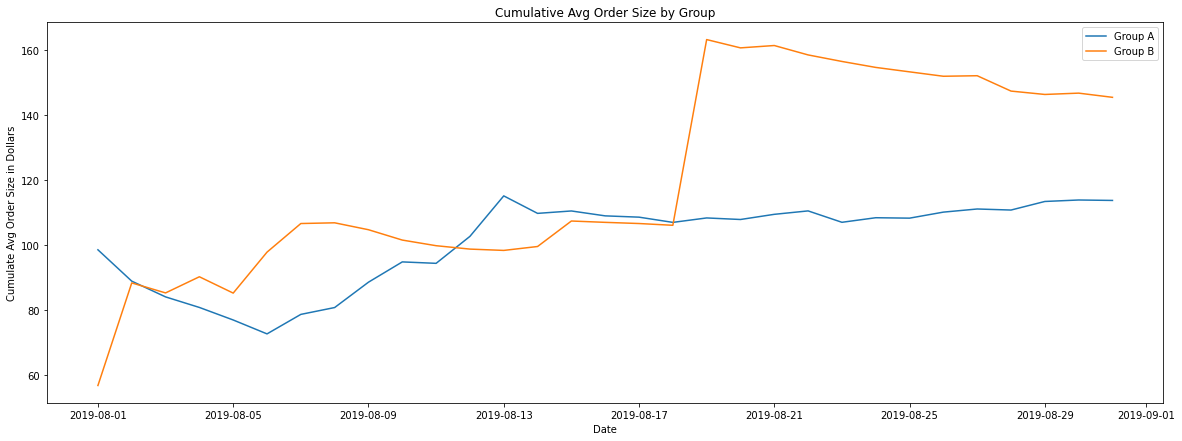

In [25]:
plt.figure(figsize = (20, 7))
plt.plot(orders_A['date'], orders_A['cum_avg_order_size'], label = 'Group A')
plt.plot(orders_B['date'], orders_B['cum_avg_order_size'], label = 'Group B')
plt.title('Cumulative Avg Order Size by Group')
plt.xlabel('Date')
plt.ylabel('Cumulate Avg Order Size in Dollars')
plt.legend()
plt.show()

#### Conclusion
##### - Similar story here - while we see a large spike in Group B, and Group B still has a commanding lead, the trend seems to be deviating, perhaps back to the mean where Group A is. However, at this time, Group B has a much higher average order size, and the differences are stable enough to make a decision.

In [26]:
# Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

In [27]:
# here's our calculation for plotting relative difference for group B
orders_B['cum_diff'] = (orders_B['cum_avg_order_size'] / orders_A['cum_avg_order_size']) - 1

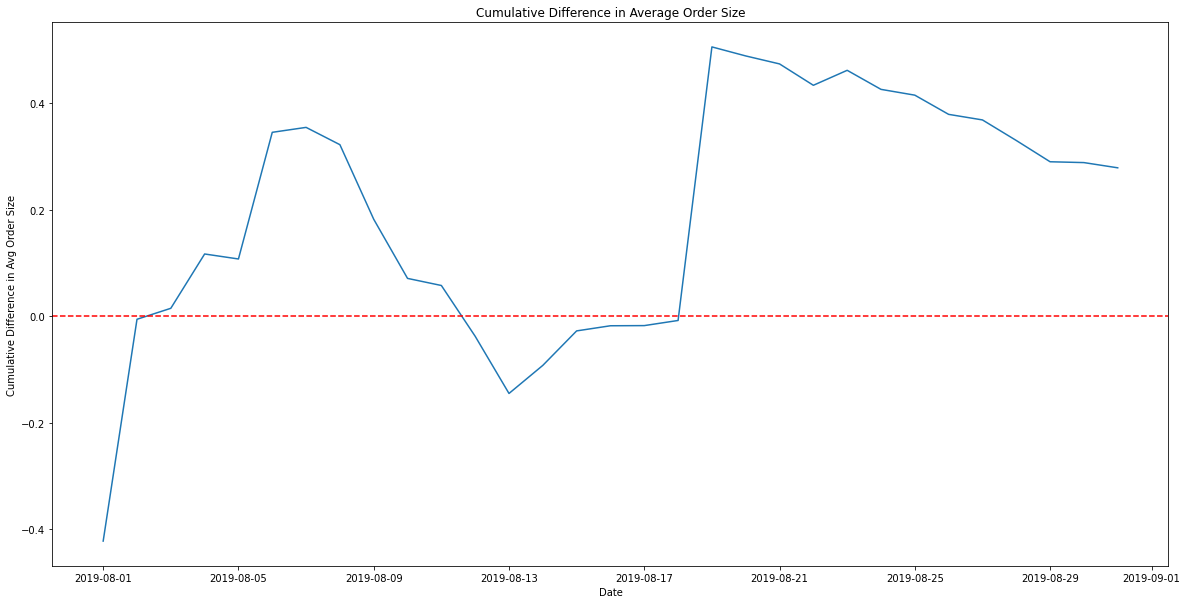

In [28]:
# plotting relative difference

plt.figure(figsize = (20, 10))
plt.plot(orders_A['date'], orders_B['cum_diff'])
plt.title('Cumulative Difference in Average Order Size')
plt.xlabel('Date')
plt.ylabel('Cumulative Difference in Avg Order Size')
plt.axhline(0, color ='r', linestyle = '--')
plt.show()

In [29]:
# Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions

In [30]:
orders_A.head()

,date,revenue,orders,cum_revenue,cum_orders,cum_avg_order_size
0,2019-08-01,2266.6,23,2266.6,23,98.547826
1,2019-08-02,1468.3,19,3734.9,42,88.926190
2,2019-08-03,1815.2,24,5550.1,66,84.092424
3,2019-08-04,675.5,11,6225.6,77,80.851948
4,2019-08-05,1398.0,22,7623.6,99,77.006061


In [31]:
# first let's calculate conversion for both groups
# start by merging visits and orders to get the number of visitors and orders together

visits_A = visits[visits['group']== 'A']
visits_B = visits[visits['group']== 'B']

orders_A = pd.merge(orders_A, visits_A, on='date')
orders_B = pd.merge(orders_B, visits_B, on='date')

In [32]:
# let's get cumulative visits for our new datasets
orders_A['cum_visits'] = orders_A['visits'].cumsum()
orders_B['cum_visits'] = orders_B['visits'].cumsum()

In [33]:
orders_A['conversion'] = orders_A['cum_orders'] / orders_A['cum_visits']
orders_B['conversion'] = orders_B['cum_orders'] / orders_A['cum_visits']

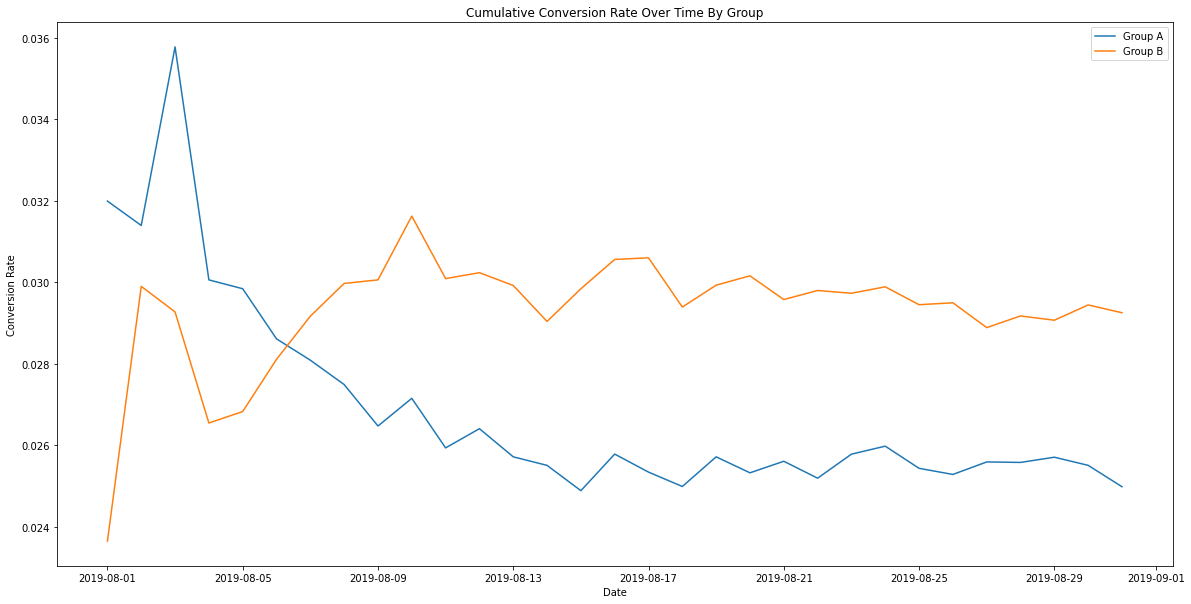

In [34]:
# plotting conversion rates for both groups

plt.figure(figsize = (20, 10))
plt.plot(orders_A['date'], orders_A['conversion'], label='Group A')
plt.plot(orders_B['date'], orders_B['conversion'], label='Group B')
plt.title('Cumulative Conversion Rate Over Time By Group')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend()
plt.show()

#### Conclusion
##### - After stabilization, Group B has a consistently better conversion rate - though, admittedly, it's not much better.

In [35]:
orders_A.head()

,date,revenue,orders,cum_revenue,cum_orders,cum_avg_order_size,group,visits,cum_visits,conversion
0,2019-08-01,2266.6,23,2266.6,23,98.547826,A,719,719,0.031989
1,2019-08-02,1468.3,19,3734.9,42,88.926190,A,619,1338,0.031390
2,2019-08-03,1815.2,24,5550.1,66,84.092424,A,507,1845,0.035772
3,2019-08-04,675.5,11,6225.6,77,80.851948,A,717,2562,0.030055
4,2019-08-05,1398.0,22,7623.6,99,77.006061,A,756,3318,0.029837


In [36]:
# Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

In [37]:
# first we'll find the number of orders per user by creating new dataframes
# we'll aggregate by group category, then visitorId

orders_per_user_A = orders[orders['group']== 'A']
orders_per_user_A = orders_per_user_A.groupby('visitorId').agg({'group_check': 'count'}).reset_index()
orders_per_user_A.columns = ['visitorId', 'order_count']
orders_per_user_A = orders_per_user_A.groupby('order_count').agg({'visitorId': 'count'}).reset_index()

orders_per_user_B = orders[orders['group']== 'B']
orders_per_user_B = orders_per_user_B.groupby('visitorId').agg({'group_check': 'count'}).reset_index()
orders_per_user_B.columns = ['visitorId', 'order_count']
orders_per_user_B = orders_per_user_B.groupby('order_count').agg({'visitorId': 'count'}).reset_index()

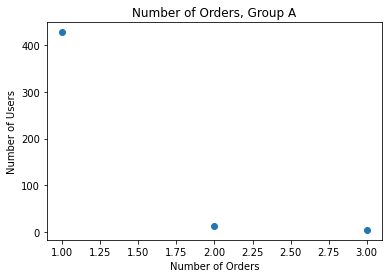

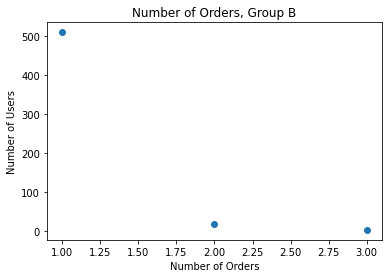

In [38]:
# we're ready to create our scatter plot

plt.scatter(orders_per_user_A['order_count'], orders_per_user_A['visitorId'])
plt.title('Number of Orders, Group A')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.show()

plt.scatter(orders_per_user_B['order_count'], orders_per_user_B['visitorId'])
plt.title('Number of Orders, Group B')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.show()

#### Conclusion
##### - Both groups have a very similar order profile.

In [39]:
# Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [40]:
# will use the original orders table instead of the grouped & filtered one

orders_A_original = orders[orders['group']=='A']
orders_B_original = orders[orders['group']=='B']

percentile_A_95 = orders_A_original.groupby('visitorId')['group'].count().quantile(.95)
percentile_A_99 = orders_A_original.groupby('visitorId')['group'].count().quantile(.99)

percentile_B_95 = orders_B_original.groupby('visitorId')['group'].count().quantile(.95)
percentile_B_99 = orders_B_original.groupby('visitorId')['group'].count().quantile(.99)


print('Number of Orders Per User, Per Group:')
print('Group A | 95 percentile:', percentile_A_95)
print('Group A | 99 percentile:', percentile_A_99)
print('Group B | 95 percentile:', percentile_B_95)
print('Group B | 99 percentile:', percentile_B_99)

Number of Orders Per User, Per Group:
Group A | 95 percentile: 1.0
Group A | 99 percentile: 2.5600000000000023
Group B | 95 percentile: 1.0
Group B | 99 percentile: 2.0


In [41]:
# Plot a scatter chart of order prices. Make conclusions and conjectures.

In [42]:
# creating revenue dataframes

orders_revenue_A = orders[orders['group']== 'A']
orders_revenue_B = orders[orders['group']== 'B']

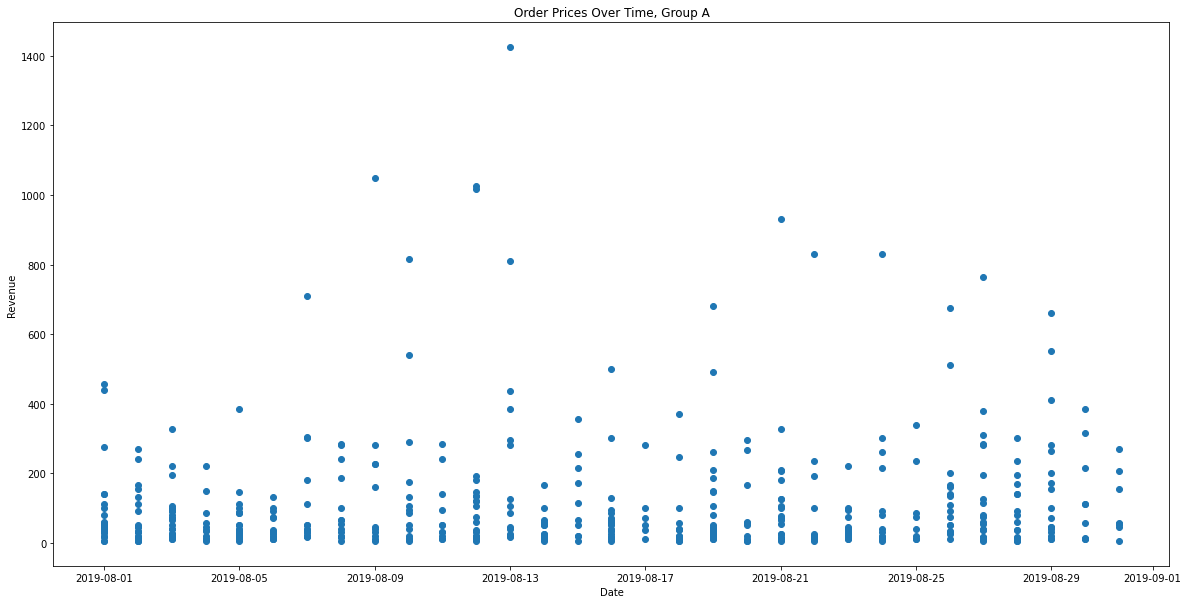

In [43]:
# scatter plot for group A

plt.figure(figsize = (20, 10))
plt.scatter(orders_revenue_A['date'], orders_revenue_A['revenue'])
plt.title('Order Prices Over Time, Group A')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

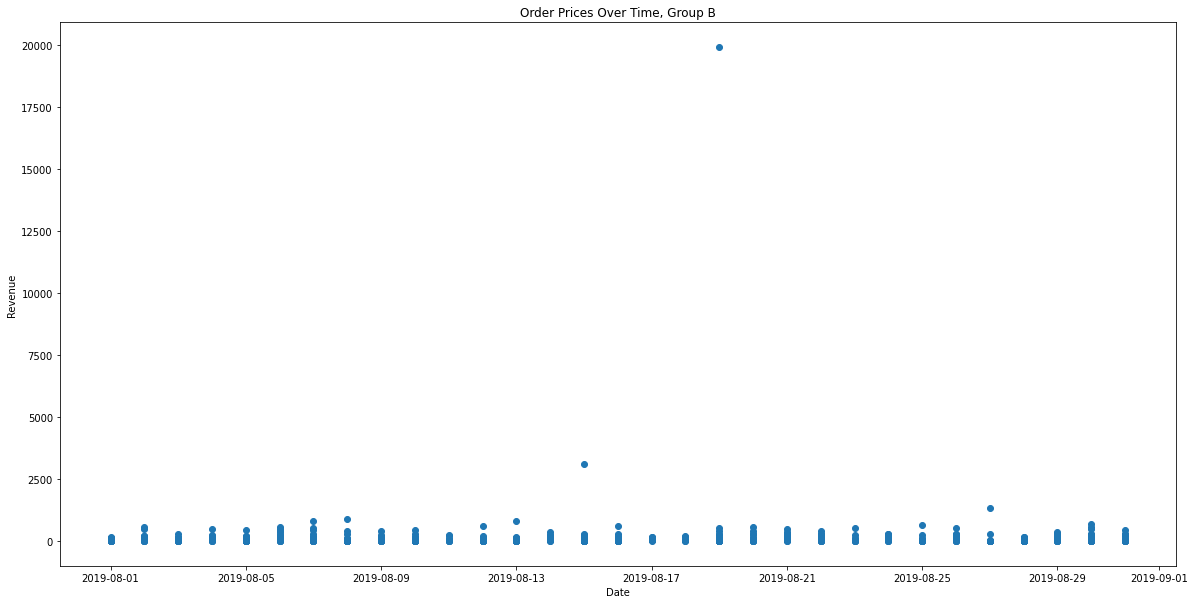

In [44]:
# plotting scatter for group B

plt.figure(figsize=(20,10))
plt.scatter(orders_revenue_B['date'],
           orders_revenue_B['revenue'])
plt.title('Order Prices Over Time, Group B')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

#### Conclusion:
##### - both group A & B have anomalies, group B's order anomalies are much larger (biggest anomaly being 2019-08-19).

In [45]:
# Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [46]:
print('Group A Order Price | 95 percentile:', np.percentile(orders_revenue_A['revenue'], [95]))
print('Group A Order Price | 99 percentile:', np.percentile(orders_revenue_A['revenue'], [99]))
print('Group B Order Price | 95 percentile:', np.percentile(orders_revenue_B['revenue'], [95]))
print('Group B Order Price | 99 percentile:', np.percentile(orders_revenue_B['revenue'], [99]))

Group A Order Price | 95 percentile: [385.63]
Group A Order Price | 99 percentile: [863.201]
Group B Order Price | 95 percentile: [425.795]
Group B Order Price | 99 percentile: [763.865]


#### Conclusion:
##### - We found the 95 & 99 percentiles for the order prices of groups A and B
##### - The data has an anomaly on 2019-08-19, where an order is placed for nearly $20,000

In [47]:
# Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

In [48]:
orders_A.head()

,date,revenue,orders,cum_revenue,cum_orders,cum_avg_order_size,group,visits,cum_visits,conversion
0,2019-08-01,2266.6,23,2266.6,23,98.547826,A,719,719,0.031989
1,2019-08-02,1468.3,19,3734.9,42,88.926190,A,619,1338,0.031390
2,2019-08-03,1815.2,24,5550.1,66,84.092424,A,507,1845,0.035772
3,2019-08-04,675.5,11,6225.6,77,80.851948,A,717,2562,0.030055
4,2019-08-05,1398.0,22,7623.6,99,77.006061,A,756,3318,0.029837


In [49]:
# creating new orders dataframes, grouping by visitorId and aggregating by transactionId

orders_A_stat_sig = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' :pd.Series.nunique})
orders_A_stat_sig.columns = ['visitorId', 'orders']

orders_B_stat_sig = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' :pd.Series.nunique})
orders_B_stat_sig.columns = ['visitorId', 'orders']

In [50]:
# concatenating new dfs

sample_A = pd.concat([orders_A_stat_sig['orders'],
                      pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(orders_A_stat_sig['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_B_stat_sig['orders'],
                      pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(orders_B_stat_sig['orders'])), name='orders')],axis=0)

In [51]:
# conducting a mann-whitney hypothesis test

# define alpha

alpha = 0.05

conversion_results = st.mannwhitneyu(sample_A, sample_B, True, 'less')

print('p-value:', conversion_results.pvalue)

if (conversion_results.pvalue > alpha):
    print('Failed to reject null hypothesis: not statistically significant')
    
else:
    print('Rejected null hypothesis: statistically significant')

p-value: 0.005509042055007348
Rejected null hypothesis: statistically significant


#### Conlcusion:
##### - There is a statistically significant difference in conversion rates between groups.

In [52]:
# Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

In [53]:
# conducting another mann-whitney test

order_size_sample_A = orders[orders['group']== 'A']['revenue']
order_size_sample_B = orders[orders['group']== 'B']['revenue']

In [54]:
order_size_results = st.mannwhitneyu(order_size_sample_A, order_size_sample_B)

print('p-value:', order_size_results.pvalue)

if (order_size_results.pvalue > alpha):
    print('Failed to reject null hypothesis: not statistically significant')
    
else:
    print('Rejected null hypothesis: statistically significant')

p-value: 0.8622329690015668
Failed to reject null hypothesis: not statistically significant


#### Conclusion:
##### - No statistically significant difference in average order size between groups.

In [55]:
# Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

In [56]:
orders_A.head()

,date,revenue,orders,cum_revenue,cum_orders,cum_avg_order_size,group,visits,cum_visits,conversion
0,2019-08-01,2266.6,23,2266.6,23,98.547826,A,719,719,0.031989
1,2019-08-02,1468.3,19,3734.9,42,88.926190,A,619,1338,0.031390
2,2019-08-03,1815.2,24,5550.1,66,84.092424,A,507,1845,0.035772
3,2019-08-04,675.5,11,6225.6,77,80.851948,A,717,2562,0.030055
4,2019-08-05,1398.0,22,7623.6,99,77.006061,A,756,3318,0.029837


In [57]:
orders_B.head()

,date,revenue,orders,cum_revenue,cum_orders,cum_avg_order_size,cum_diff,group,visits,cum_visits,conversion
0,2019-08-01,967.2,17,967.2,17,56.894118,-0.422675,B,713,713,0.023644
1,2019-08-02,2568.1,23,3535.3,40,88.382500,-0.006114,B,581,1294,0.029895
2,2019-08-03,1071.6,14,4606.9,54,85.312963,0.014514,B,509,1803,0.029268
3,2019-08-04,1531.6,14,6138.5,68,90.272059,0.116511,B,770,2573,0.026542
4,2019-08-05,1449.3,21,7587.8,89,85.256180,0.107136,B,707,3280,0.026823


In [58]:
#CORRECTED 
users_many_orders = pd.concat([orders_A_stat_sig[orders_A_stat_sig['orders'] > 2]['visitorId'], orders_B_stat_sig[orders_B_stat_sig['orders'] > 2]['visitorId']], axis = 0)

users_expensive_orders = orders[orders['revenue'] > 900]['visitorId']

abnormal_users = pd.concat([users_many_orders,  users_expensive_orders], axis = 0).drop_duplicates().sort_values()


In [59]:
#CORRECTED 
sampleA_filtered = pd.concat(
[
    orders_A_stat_sig[
        np.logical_not(orders_A_stat_sig['visitorId'].isin(abnormal_users))
    ]['orders'],
    pd.Series(
        0,
        index=np.arange(
            visits[visits['group'] == 'A']['visits'].sum()
            - len(orders_A_stat_sig['orders'])
        ),
        name='orders',
    ),
],
axis=0,)

In [60]:
#CORRECTED 
sampleB_filtered = pd.concat(
[
    orders_B_stat_sig[
        np.logical_not(orders_B_stat_sig['visitorId'].isin(abnormal_users))
    ]['orders'],
    pd.Series(
        0,
        index=np.arange(
            visits[visits['group'] == 'B']['visits'].sum()
            - len(orders_B_stat_sig['orders'])
        ),
        name='orders',
    ),
],
axis=0,)

In [61]:
alpha = 0.05
filtered_conversion_results = st.mannwhitneyu(sampleA_filtered, sampleB_filtered)

print('pvalue:',round(filtered_conversion_results.pvalue, 4))
print()

if (filtered_conversion_results.pvalue > alpha):
    print('Failed to reject null hypothesis: we can not make conclusions about the difference.')
else:
    print('Null hypothesis rejected: the difference is statisticaly significant.')

pvalue: 0.007

Null hypothesis rejected: the difference is statisticaly significant.


#### Conclusion
##### - The differences in conversion rates are statistically significant

In [62]:
# Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

In [63]:
sampleA_filtered_order_size = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue']

sampleB_filtered_order_size = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue']

In [64]:
filtered_results_order_size = st.mannwhitneyu(sampleA_filtered_order_size, sampleB_filtered_order_size)

print('pvalue:',round(filtered_results_order_size.pvalue,4))
print()

if (filtered_results_order_size.pvalue > alpha):
    print('Failed to reject null hypothesis: we can not make conclusions about the difference.')
else:
    print('Null hypothesis rejected: the difference is statisticaly significant.')

pvalue: 0.822

Failed to reject null hypothesis: we can not make conclusions about the difference.


In [65]:
# Extract the average order size for groups A and B
avg_order_size_A = orders_A['cum_avg_order_size']
avg_order_size_B = orders_B['cum_avg_order_size']

# Perform the independent samples t-test
t_statistic, p_value = st.ttest_ind(avg_order_size_A, avg_order_size_B, equal_var=False)

# Print the p-value
print("p-value:", p_value)

if (p_value > alpha):
    print('Failed to reject null hypothesis: not statistically significant')
    
else:
    print('Rejected null hypothesis: statistically significant')

p-value: 0.0018233208993919169
Rejected null hypothesis: statistically significant


#### Conclusion
##### - Here we see that the difference in average order size between groups is indeed statistically significant.

In [66]:
# Make a decision based on the test results. The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.

# Final Conclusion
# According to the raw data, there is not a statistically significant difference in average order size between groups.
# There is, however, a statistically significant difference in conversion - Group B converts at a higher rate.